
------

### ---- EXPLORACIÓN 20 RATAS SANAS : FILTRADO, PROMEDIO Y SELECCIÓN ---- Caso th = 0.4
#### DATOS ALEJANDRO RATAS (1-20) 13.10.25

------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os

In [2]:
# HELPER FUNCTIONS

def _safe_stat(x, stat="median"):
    """Devuelve np.nan si no hay valores finitos; evita All-NaN slice."""
    x = np.asarray(x)
    m = np.isfinite(x)
    if not m.any():
        return np.nan
    return (np.median if stat == "median" else np.mean)(x[m])


def _sym_avg_nan(M):
    """Media simétrica sin warnings: usa promedio ponderado por disponibilidad."""
    A, B = M, M.T
    denom = (~np.isnan(A)).astype(float) + (~np.isnan(B)).astype(float)
    num   = np.nan_to_num(A) + np.nan_to_num(B)
    out   = num / np.where(denom == 0, np.nan, denom)
    out[denom == 0] = np.nan
    return out

# Límites de color (limpios) para ser consistentes entre mapas
def _vlims(M):
    vals = M[~np.isnan(M)]
    return (np.nanpercentile(vals, 1), np.nanpercentile(vals, 99)) if vals.size else (None, None)

def _hemi_guides(ax, h):
    ax.axhline(h-0.5, color='w', lw=0.8)
    ax.axvline(h-0.5, color='w', lw=0.8)

# --- Construcción robusta del name_map con IDs reales ---
def make_name_map_from_ids(roi_names, left_ids, right_ids):
    """
    roi_names: lista de 78 nombres base en el orden correcto del atlas.
    left_ids, right_ids: listas con los IDs REALES que corresponden a esos 78 nombres.
                         Deben tener len()==len(roi_names).
    Devuelve dict {roi_id: "L-<name>" / "R-<name>"}.
    """
    if len(left_ids) != len(roi_names) or len(right_ids) != len(roi_names):
        raise ValueError("left_ids y right_ids deben tener la misma longitud que roi_names (78).")

    name_map = {}
    for k, rid in enumerate(left_ids):
        name_map[int(rid)] = f"L-{roi_names[k]}"
    for k, rid in enumerate(right_ids):
        name_map[int(rid)] = f"R-{roi_names[k]}"
    return name_map

# --- Etiquetador que NO asume contigüidad ---
def roi_label(idx, name_map):
    """
    idx: ROI id real (disperso). name_map: dict {id: 'L-Name'/'R-Name'}.
    """
    try:
        return name_map[int(idx)]
    except KeyError:
        return f"ID{int(idx)}"  # fallback visible

## 2. Diferencias clave con el notebook de 1 rata

| Aspecto | Notebook actual | Nuevo enfoque multi-rata |
|---------|-----------------|--------------------------|
| Input | `pickle` con delays crudos | `.dat` con fits (medias/stds) |
| Estructura | `dict[(i,j)] → array(N×6)` | Probablemente matriz o lista de parámetros |
| n_fibers | Por streamline | Agregado en el fit |
| CV/dispersión | Calculado desde delays | Ya resumido o recalcular desde parámetros |
| Multi-sujeto | No aplica | Agregar/promediar entre 18 ratas |

## 3. Flujo propuesto (adaptado)

### Fase A: Carga y consolidación
1. **Leer todos los `.dat`** → tabla unificada por rata
2. **Estructura target**: `DataFrame` con columnas:
   - `rat_id`, `roi_i`, `roi_j`, `n_fibers`, `tau_mean_ms`, `tau_std_ms`, ...
3. **Filtrar conexiones**: `n_fibers ≥ umbral` (50-100)

### Fase B: Análisis por rata y agregado
4. **Métricas por rata**:
   - Distribuciones de τ por conexión
   - Relación τ~D (si D está en los fits)
5. **Agregación entre ratas**:
   - Media/mediana de τ por conexión (i,j) across ratas
   - Variabilidad inter-sujeto (CV entre ratas)
6. **Selección robusta**:
   - Conexiones presentes en ≥ N/2 ratas (e.g., ≥10/18)
   - Bajo CV inter-rata
   - Buen n_fibers promedio



### Fase C: Categorización y clustering
7. Aplicar misma lógica del notebook:
   - Intra/inter hemisférico
   - Hipocampo-PFC, tálamo-cortical
   - Clustering por forma de distribución (si hay parámetros de fit suficientes)

### 1. Carga consolidada - Nombres + Datos

In [3]:
os.chdir("../..")

path = './data/raw/rat_delays_fibers_0.4/th-0.4/'

names = [f for f in os.listdir(path) if 'name' in f]

# Abrir archivo .txt con nombres de ROIs y .dat con datos en formato diccionario
with open(path+names[0], 'r') as f:
    roi_names = [line.strip() for line in f.readlines()][1:]
    
print(roi_names), len(roi_names)

['White matter', 'Ventricles', 'Superior colliculus', 'Olfactory bulb', 'Lateral lemniscus', 'Inferior colliculus', 'Secondary auditory area', 'Piriform cortex', 'Substantia nigra', 'Zona incerta', 'Agranular insular cortex', 'Primary somatosensory area', 'Parietal association cortex', 'Secondary visual area', 'EPI', 'LAT', 'MED', 'GENd', 'VENT', 'SPF', 'ATN', 'MTN', 'ILM', 'RT', 'GENv', 'Peri-Subiculum', 'Nucleus accumbens', 'Globus pallidus external', 'Hippocampus', 'Subiculum', 'Subthalamic nucleus', 'Cingulate area 2', 'Entopeduncular nucleus', 'Septal region', 'Brainstem, unspecified', 'Hypothalamic region, unspecified', 'Periaqueductal gray', 'Pontine nuclei', 'Interpeduncular nucleus', 'Frontal association cortex', 'Nucleus of the stria medullaris', 'Basal forebrain region, unspecified', 'Bed nucleus of the stria terminalis', 'Pretectal region', 'Postrhinal cortex', 'Perirhinal area 35', 'Perirhinal area 36', 'Medial entorhinal cortex', 'Lateral entorhinal cortex', 'Primary audi

(None, 78)

In [4]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path

def load_all_rats(data_dir, threshold='0.4'):
    """Carga 18 ratas → dict {rat_id: data_dict}"""
    rats = {}
    path = Path(data_dir) / f'rat_delays_fibers_{threshold}' / f'th-{threshold}'
    
    for f in path.glob(f'th-{threshold}_R*_b20_r_Fit_Histogram_Tau_all_fibers.dat'):
        rat_id = f.stem.split('_')[1]  # 'R01', 'R02', etc.
        with open(f, 'rb') as fh:
            rats[rat_id] = pickle.load(fh)
    
    return rats

# Uso
data_dir = './data/raw/'
all_rats = load_all_rats(data_dir, threshold='0.4')
print(f"Ratas cargadas: {sorted(all_rats.keys())}")  # R01-R19 (sin R11)
print(f"Ejemplo estructura R01: {len(all_rats['R01'])} conexiones")

Ratas cargadas: ['R01', 'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19']
Ejemplo estructura R01: 3937 conexiones


### Celda 4: Name map y exploración inicial

In [5]:
left_ids = range(0, 78)   # IDs del 1 al 78 para hemisferio izquierdo
right_ids = range(78, 156)

name_map = make_name_map_from_ids(roi_names, left_ids, right_ids)

# Exploración: conexiones comunes entre ratas
from collections import Counter
all_pairs = Counter()
for rat_data in all_rats.values():
    all_pairs.update(rat_data.keys())

print(f"Total conexiones únicas: {len(all_pairs)}")
print(f"Conexiones en ≥10 ratas: {sum(1 for c in all_pairs.values() if c >= 10)}")
print(f"\nTop 10 conexiones más frecuentes:")
for (i,j), count in all_pairs.most_common(10):
    print(f"  {roi_label(i, name_map)} → {roi_label(j, name_map)}: {count} ratas")

Total conexiones únicas: 7259
Conexiones en ≥10 ratas: 3190

Top 10 conexiones más frecuentes:
  L-Olfactory bulb → L-Secondary auditory area: 18 ratas
  L-Olfactory bulb → L-Nucleus accumbens: 18 ratas
  L-Olfactory bulb → L-Subiculum: 18 ratas
  L-Olfactory bulb → L-Subthalamic nucleus: 18 ratas
  L-Olfactory bulb → L-Entopeduncular nucleus: 18 ratas
  L-Olfactory bulb → L-Hypothalamic region, unspecified: 18 ratas
  L-Olfactory bulb → L-Pontine nuclei: 18 ratas
  L-Olfactory bulb → L-Postrhinal cortex: 18 ratas
  L-Olfactory bulb → L-Secondary somatosensory area: 18 ratas
  L-Olfactory bulb → L-Primary motor area: 18 ratas


### Celda 5: Limpieza por rata
    - Min fibers: 25

In [6]:
import numpy as np
import pandas as pd

# Columnas (D y V no se usan en la limpieza; se dejan por compatibilidad)
COL_TAU = 0
COL_D   = 1
COL_V   = 2

def clean_data(
    data: dict,
    *,
    min_n_fibers: int = 50,
    enforce_positive: bool = True,
    tau_quantiles: tuple[float, float] | None = (0.005, 0.995),
) -> tuple[dict, pd.DataFrame, dict]:
    """
    Limpia mediciones por par (i,j) sin chequeo τ≈D/V.
    - Filtros: finitos, (opcional) τ,D,V > 0, cuantiles de τ por par.
    - Umbral min_n_fibers antes y después de limpiar.
    Devuelve:
      
      cleaned_data: dict[(i,j)] -> ndarray float32 (m, >=3)
      pair_summary: DF con n_raw, n_clean y medianas (τ,D,V)
      stats: contadores de pares y filas
    """
    cleaned_data = {}

    pair_stats = {
        "pairs_original": len(data),
        "pairs_empty_raw": 0,
        "pairs_raw_lt_min": 0,
        "pairs_all_invalid": 0,
        "pairs_after_lt_min": 0,
        "pairs_kept": 0,
    }
    row_stats = {
        "rows_total": 0,
        "rows_kept": 0,
        "rows_drop_nan_inf": 0,
        "rows_drop_nonpositive": 0,
        "rows_drop_outlier_tau": 0,
    }

    rows_summary = []

    for (i, j), measurements in data.items():
        if measurements is None or len(measurements) == 0:
            pair_stats["pairs_empty_raw"] += 1
            continue

        arr = np.asarray(measurements)
        # exigimos al menos τ,D,V (>=3 columnas)
        if arr.ndim != 2 or arr.shape[1] < 3:
            pair_stats["pairs_all_invalid"] += 1
            continue

        n_raw = arr.shape[0]
        row_stats["rows_total"] += n_raw
        if n_raw < min_n_fibers:
            pair_stats["pairs_raw_lt_min"] += 1
            continue

        # Finite en τ,D,V
        finite = np.isfinite(arr[:, [COL_TAU, COL_D, COL_V]]).all(axis=1)
        row_stats["rows_drop_nan_inf"] += int((~finite).sum())
        arr = arr[finite]
        if arr.size == 0:
            pair_stats["pairs_all_invalid"] += 1
            continue

        # Positivos (opcional)
        if enforce_positive:
            pos = (arr[:, COL_TAU] > 0) & (arr[:, COL_D] > 0) & (arr[:, COL_V] > 0)
            row_stats["rows_drop_nonpositive"] += int((~pos).sum())
            arr = arr[pos]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        # Outliers de τ por cuantiles (por par)
        if tau_quantiles is not None and arr.shape[0] >= 5:
            qlo, qhi = tau_quantiles
            tau_vals = arr[:, COL_TAU]
            lo = np.nanquantile(tau_vals, qlo)
            hi = np.nanquantile(tau_vals, qhi)
            in_rng = (tau_vals >= lo) & (tau_vals <= hi)
            row_stats["rows_drop_outlier_tau"] += int((~in_rng).sum())
            arr = arr[in_rng]
            if arr.size == 0:
                pair_stats["pairs_all_invalid"] += 1
                continue

        n_clean = arr.shape[0]
        if n_clean < min_n_fibers:
            pair_stats["pairs_after_lt_min"] += 1
            continue

        cleaned = arr.astype(np.float32, copy=False)
        cleaned_data[(int(i), int(j))] = cleaned
        pair_stats["pairs_kept"] += 1
        row_stats["rows_kept"] += n_clean

        # Resumen por par
        med_tau = float(np.median(cleaned[:, COL_TAU]))
        med_D   = float(np.median(cleaned[:, COL_D]))
        med_V   = float(np.median(cleaned[:, COL_V]))

        rows_summary.append({
            "roi_i": int(i), "roi_j": int(j),
            "roi_name1": roi_label(i, name_map), "roi_name2": roi_label(j, name_map),
            "n_raw": int(n_raw), "n_clean": int(n_clean),
            "tau_med_s": med_tau, "tau_med_ms": med_tau*1e3,
            "D_med_m": med_D, "D_med_mm": med_D*1e3,
            "V_med_mps": med_V,
        })

    pair_summary = pd.DataFrame(rows_summary).sort_values(["roi_i", "roi_j"]).reset_index(drop=True)
    stats = {"pairs": pair_stats, "rows": row_stats}
    return cleaned_data, pair_summary, stats


cleaned_rats = {}
summaries = {}
stats = {}
for rat_id, data in all_rats.items():
    cleaned_rats[rat_id], summaries[rat_id], stats[rat_id] = clean_data(
        data, min_n_fibers=25, enforce_positive=True, tau_quantiles=(0.0, 1.0)
    )
cleaned_rats.keys()

dict_keys(['R02', 'R19', 'R12', 'R03', 'R13', 'R06', 'R16', 'R18', 'R08', 'R10', 'R17', 'R15', 'R05', 'R09', 'R14', 'R07', 'R04', 'R01'])

### - Mostramos los resultados para una rata: 02

    - Claves de pares de ROIs (i,j)

In [7]:
cleaned_rats['R02'].keys()

dict_keys([(3, 6), (3, 16), (3, 18), (3, 23), (3, 26), (3, 29), (3, 30), (3, 35), (3, 37), (3, 44), (3, 48), (3, 58), (3, 59), (3, 60), (3, 69), (3, 82), (3, 105), (3, 109), (3, 124), (3, 127), (3, 139), (3, 145), (4, 8), (4, 9), (4, 24), (4, 25), (4, 27), (4, 28), (4, 29), (4, 35), (4, 38), (4, 42), (4, 51), (4, 53), (4, 54), (4, 62), (4, 63), (5, 6), (5, 9), (5, 10), (5, 18), (5, 19), (5, 23), (5, 24), (5, 28), (5, 31), (5, 33), (5, 35), (5, 38), (5, 42), (5, 53), (5, 58), (5, 59), (5, 117), (6, 16), (6, 18), (6, 19), (6, 23), (6, 35), (6, 37), (6, 44), (7, 12), (7, 13), (7, 14), (7, 18), (7, 25), (7, 29), (7, 45), (7, 46), (7, 47), (7, 49), (7, 50), (7, 53), (7, 56), (7, 57), (7, 59), (7, 61), (7, 65), (7, 66), (7, 67), (7, 68), (7, 72), (8, 24), (8, 27), (8, 29), (8, 42), (8, 51), (8, 53), (8, 54), (8, 62), (8, 63), (8, 74), (9, 10), (9, 19), (9, 23), (9, 24), (9, 27), (9, 28), (9, 29), (9, 31), (9, 33), (9, 35), (9, 36), (9, 38), (9, 39), (9, 40), (9, 41), (9, 42), (9, 43), (9, 51

### - Resumen de estadísticas descriptivas: Pares, nombres, n_fibras_raw vs n_fibras_clean, medianas de: tau, distancia, velocity

In [8]:
summaries['R02']

,roi_i,roi_j,roi_name1,roi_name2,n_raw,n_clean,tau_med_s,tau_med_ms,D_med_m,D_med_mm,V_med_mps
0,3,6,L-Olfactory bulb,L-Secondary auditory area,86,86,0.000193,0.193214,0.001743,1.742872,9.355210
1,3,16,L-Olfactory bulb,L-MED,56,55,0.000120,0.120136,0.001198,1.197983,9.320947
2,3,18,L-Olfactory bulb,L-VENT,46,46,0.000246,0.246104,0.001957,1.956594,8.233237
3,3,23,L-Olfactory bulb,L-RT,49,49,0.000223,0.223002,0.001995,1.994544,8.937934
4,3,26,L-Olfactory bulb,L-Nucleus accumbens,326,318,0.000273,0.272805,0.001124,1.123531,4.057448
...,...,...,...,...,...,...,...,...,...,...,...
1387,142,151,R-Temporal association cortex,R-Lateral orbital area,36,36,0.000914,0.914289,0.006812,6.811522,7.454213
1388,145,148,R-Claustrum,R-Prelimbic area,524,524,0.001517,1.516832,0.009355,9.355000,6.026607
1389,148,150,R-Prelimbic area,R-Ventrolateral orbital area,349,349,0.000189,0.189249,0.001055,1.054658,5.835845
1390,149,150,R-Frontal association area 3,R-Ventrolateral orbital area,94,92,0.000143,0.143065,0.000805,0.804950,3.065631


- ### Original vs kept pairs, n_rows...
  
    - Configuración usada:

        - min_n_fibers=25 (más permisivo que el típico 50)
        - tau_quantiles=(0.0, 1.0) → sin filtrado de outliers τ
        - Mantiene positivos y finitos

    - Resultado R02 (ejemplo):

        - 3283 → 1392 pares (42% retenido)
        - 468K → 459K filas (98% streamlines OK)
        - Pérdidas principales: pares con n<25 (1282) y vacíos (605)

In [9]:
stats['R02']

{'pairs': {'pairs_original': 3283,
  'pairs_empty_raw': 605,
  'pairs_raw_lt_min': 1282,
  'pairs_all_invalid': 0,
  'pairs_after_lt_min': 4,
  'pairs_kept': 1392},
 'rows': {'rows_total': 468727,
  'rows_kept': 458976,
  'rows_drop_nan_inf': 783,
  'rows_drop_nonpositive': 415,
  'rows_drop_outlier_tau': 0}}

- ### Agregación inter-rata con métricas clave
  - Ordenado por tau_range_mean (prioriza diversidad temporal) + n_rats.

In [10]:
def aggregate_multi_rat(cleaned_rats, min_rats=10):
    """
    Consolida conexiones presentes en ≥min_rats.
    Devuelve DataFrame con estadísticas inter-rata.
    """
    from collections import defaultdict
    
    conn_data = defaultdict(lambda: {
        'rats': [], 'tau_med_ms': [], 'tau_range_ms': [], 
        'n_fibers': [], 'D_med_mm': []
    })
    
    for rat_id, data in cleaned_rats.items():
        for (i,j), arr in data.items():
            tau_ms = arr[:, COL_TAU] * 1e3
            D_mm = arr[:, COL_D] * 1e3
            
            conn_data[(i,j)]['rats'].append(rat_id)
            conn_data[(i,j)]['tau_med_ms'].append(np.median(tau_ms))
            conn_data[(i,j)]['tau_range_ms'].append(np.ptp(tau_ms))  # max-min
            conn_data[(i,j)]['n_fibers'].append(len(tau_ms))
            conn_data[(i,j)]['D_med_mm'].append(np.median(D_mm))
    
    rows = []
    for (i,j), stats in conn_data.items():
        n_rats = len(stats['rats'])
        if n_rats < min_rats:
            continue
        
        tau_vals = np.array(stats['tau_med_ms'])
        rows.append({
            'roi_i': int(i), 'roi_j': int(j),
            'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
            'n_rats': n_rats,
            'tau_mean_ms': tau_vals.mean(),
            'tau_std_inter': tau_vals.std(),           # variabilidad entre ratas
            'cv_inter': tau_vals.std() / tau_vals.mean(),
            'tau_range_mean': np.mean(stats['tau_range_ms']),  # rango promedio
            'n_fibers_mean': np.mean(stats['n_fibers']),
            'D_mean_mm': np.mean(stats['D_med_mm']),
            'hemi': 'intra' if (i < 78 and j < 78) or (i >= 78 and j >= 78) else 'inter',
        })
    
    df = pd.DataFrame(rows)
    return df.sort_values(['tau_range_mean', 'n_rats'], ascending=[False, False])

df_multi = aggregate_multi_rat(cleaned_rats, min_rats=9)
print(f"Conexiones con ≥10 ratas: {len(df_multi)}")
df_multi.head(20)

Conexiones con ≥10 ratas: 1207


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
421,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.927334,0.114198,0.123146,2.844416,1954.166667,6.166801,intra
779,103,114,R-Peri-Subiculum → R-Periaqueductal gray,18,0.891554,0.170247,0.190956,2.712363,1358.055556,5.994340,intra
298,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",18,1.189199,0.168987,0.142102,2.625037,2046.666667,8.000906,intra
332,29,59,L-Subiculum → L-Retrosplenial granular area,18,1.107590,0.307035,0.277210,2.611728,1238.611111,6.220019,intra
872,114,121,R-Periaqueductal gray → R-Pretectal region,18,0.823925,0.125027,0.151746,2.604825,2438.944444,5.706488,intra
960,139,148,R-Endopiriform nucleus → R-Prelimbic area,18,1.548511,0.490643,0.316848,2.547088,278.722222,6.026229,intra
825,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,18,0.547308,0.111320,0.203395,2.544925,2924.500000,3.012940,intra
877,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.221023,0.142707,0.116875,2.543901,4965.944444,7.900550,intra
426,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",18,1.285350,0.164176,0.127729,2.542680,2388.055556,8.559130,intra
327,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.730488,0.087805,0.120200,2.512787,5951.555556,4.048223,intra


### Top 20 con mayor rango temporal (2.4-2.8 ms):
- Patrones clave:

  - Todos intra-hemisféricos subcorticales/límbicos
  - 18/18 ratas en todos (máxima robustez)
  - CV_inter: 0.12-0.55 (algunos muy estables, otros más variables entre sujetos)
  - Protagonistas: Hipotálamo, Subiculum, PAG, Zona incerta

In [11]:
# 1. Filtrar por estabilidad inter-rata + n_fibers alto
df_stable_diverse = df_multi[
    (df_multi['n_rats'] >= 9) &
    (df_multi['cv_inter'] < 0.5) &
    (df_multi['n_fibers_mean'] >= 100) &
    (df_multi['tau_range_mean'] > 2.0)
].sort_values('tau_range_mean', ascending=False)

print(f"Candidatos estables con alta diversidad: {len(df_stable_diverse)}")
df_stable_diverse.head(15)

Candidatos estables con alta diversidad: 61


,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
421,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.927334,0.114198,0.123146,2.844416,1954.166667,6.166801,intra
779,103,114,R-Peri-Subiculum → R-Periaqueductal gray,18,0.891554,0.170247,0.190956,2.712363,1358.055556,5.994340,intra
298,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",18,1.189199,0.168987,0.142102,2.625037,2046.666667,8.000906,intra
332,29,59,L-Subiculum → L-Retrosplenial granular area,18,1.107590,0.307035,0.277210,2.611728,1238.611111,6.220019,intra
872,114,121,R-Periaqueductal gray → R-Pretectal region,18,0.823925,0.125027,0.151746,2.604825,2438.944444,5.706488,intra
960,139,148,R-Endopiriform nucleus → R-Prelimbic area,18,1.548511,0.490643,0.316848,2.547088,278.722222,6.026229,intra
825,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,18,0.547308,0.111320,0.203395,2.544925,2924.500000,3.012940,intra
877,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.221023,0.142707,0.116875,2.543901,4965.944444,7.900550,intra
426,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",18,1.285350,0.164176,0.127729,2.542680,2388.055556,8.559130,intra
327,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.730488,0.087805,0.120200,2.512787,5951.555556,4.048223,intra


#6: R-Endopiriform→Prelimbic (CV=0.32, n=279) - más variable pero presente
#13: L-Hypothalamic→Ventral pallidum (n=343, 17 ratas) - caso con menos sujetos

El resto mantiene CV<0.25 y n>750.

In [12]:
df_multi.sort_values('n_fibers_mean', ascending = False).head(20)

,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
327,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.730488,0.087805,0.120200,2.512787,5951.555556,4.048223,intra
877,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.221023,0.142707,0.116875,2.543901,4965.944444,7.900550,intra
302,28,53,"L-Hippocampus → L-Ventral striatal region, uns...",18,0.131465,0.024367,0.185348,1.820889,4695.222222,0.866844,intra
811,107,132,R-Subiculum → R-Retrosplenial dysgranular area,18,0.104451,0.019893,0.190451,1.372535,4321.333333,0.652686,intra
452,42,53,L-Bed nucleus of the stria terminalis → L-Vent...,18,0.316530,0.094307,0.297940,2.206930,4098.111111,1.917352,intra
806,107,114,R-Subiculum → R-Periaqueductal gray,18,1.184051,0.137325,0.115979,2.473557,3932.944444,7.554209,intra
651,88,132,R-Agranular insular cortex → R-Retrosplenial d...,18,0.926454,0.140070,0.151189,1.876431,3913.388889,5.822678,intra
641,88,107,R-Agranular insular cortex → R-Subiculum,18,0.816318,0.126216,0.154617,1.837252,3726.444444,5.076711,intra
299,28,42,L-Hippocampus → L-Bed nucleus of the stria ter...,18,0.217168,0.059916,0.275896,1.902953,3270.500000,1.173358,intra
908,121,132,R-Pretectal region → R-Retrosplenial dysgranul...,18,0.406664,0.102708,0.252564,1.941671,3043.611111,2.469482,intra


In [13]:
df_multi.sort_values('tau_range_mean', ascending = False).head(20)

,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
421,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.927334,0.114198,0.123146,2.844416,1954.166667,6.166801,intra
779,103,114,R-Peri-Subiculum → R-Periaqueductal gray,18,0.891554,0.170247,0.190956,2.712363,1358.055556,5.994340,intra
298,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",18,1.189199,0.168987,0.142102,2.625037,2046.666667,8.000906,intra
332,29,59,L-Subiculum → L-Retrosplenial granular area,18,1.107590,0.307035,0.277210,2.611728,1238.611111,6.220019,intra
872,114,121,R-Periaqueductal gray → R-Pretectal region,18,0.823925,0.125027,0.151746,2.604825,2438.944444,5.706488,intra
960,139,148,R-Endopiriform nucleus → R-Prelimbic area,18,1.548511,0.490643,0.316848,2.547088,278.722222,6.026229,intra
825,108,132,R-Subthalamic nucleus → R-Retrosplenial dysgra...,18,0.547308,0.111320,0.203395,2.544925,2924.500000,3.012940,intra
877,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.221023,0.142707,0.116875,2.543901,4965.944444,7.900550,intra
426,35,53,"L-Hypothalamic region, unspecified → L-Ventral...",18,1.285350,0.164176,0.127729,2.542680,2388.055556,8.559130,intra
327,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.730488,0.087805,0.120200,2.512787,5951.555556,4.048223,intra


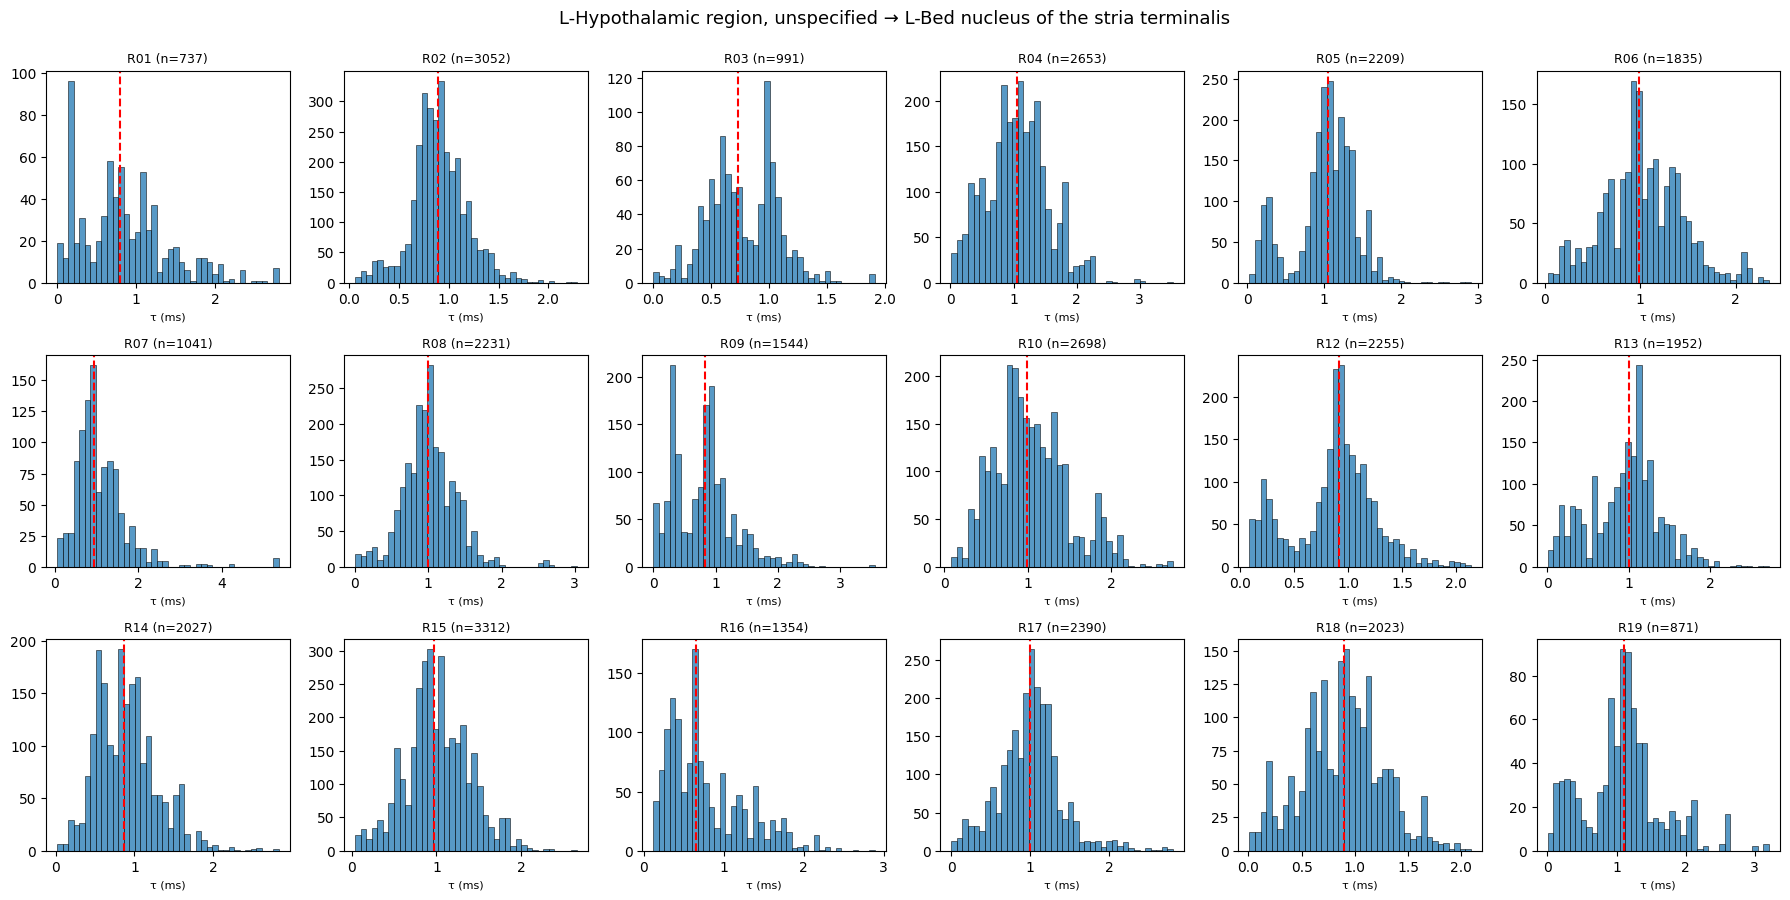

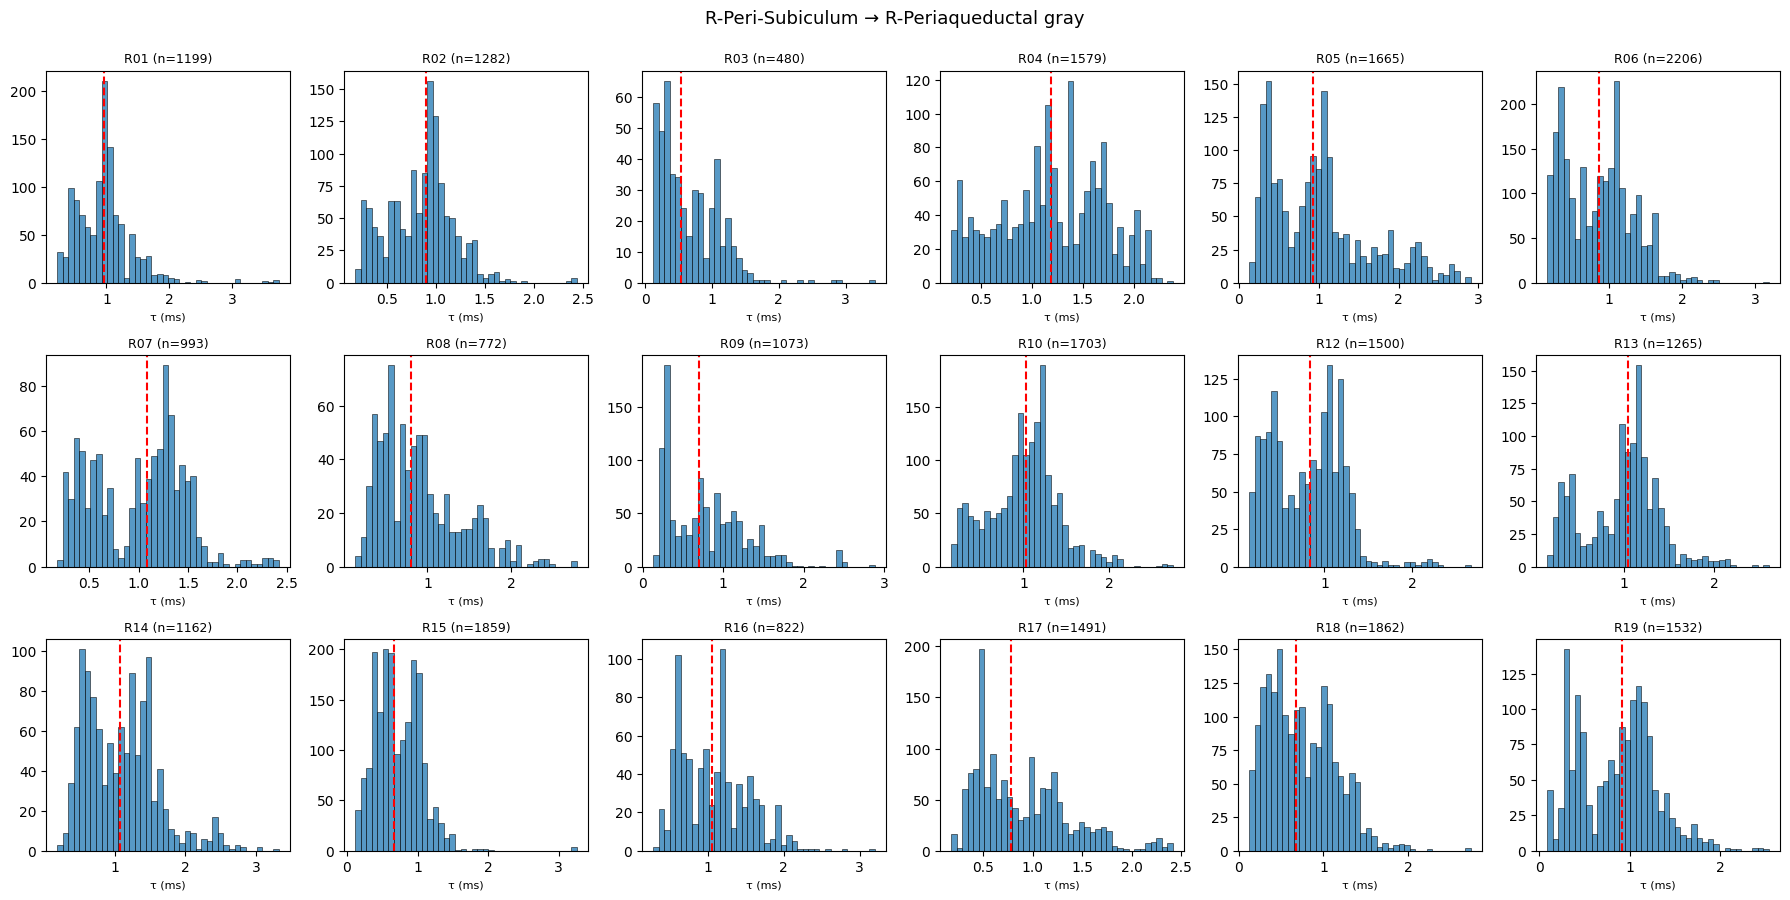

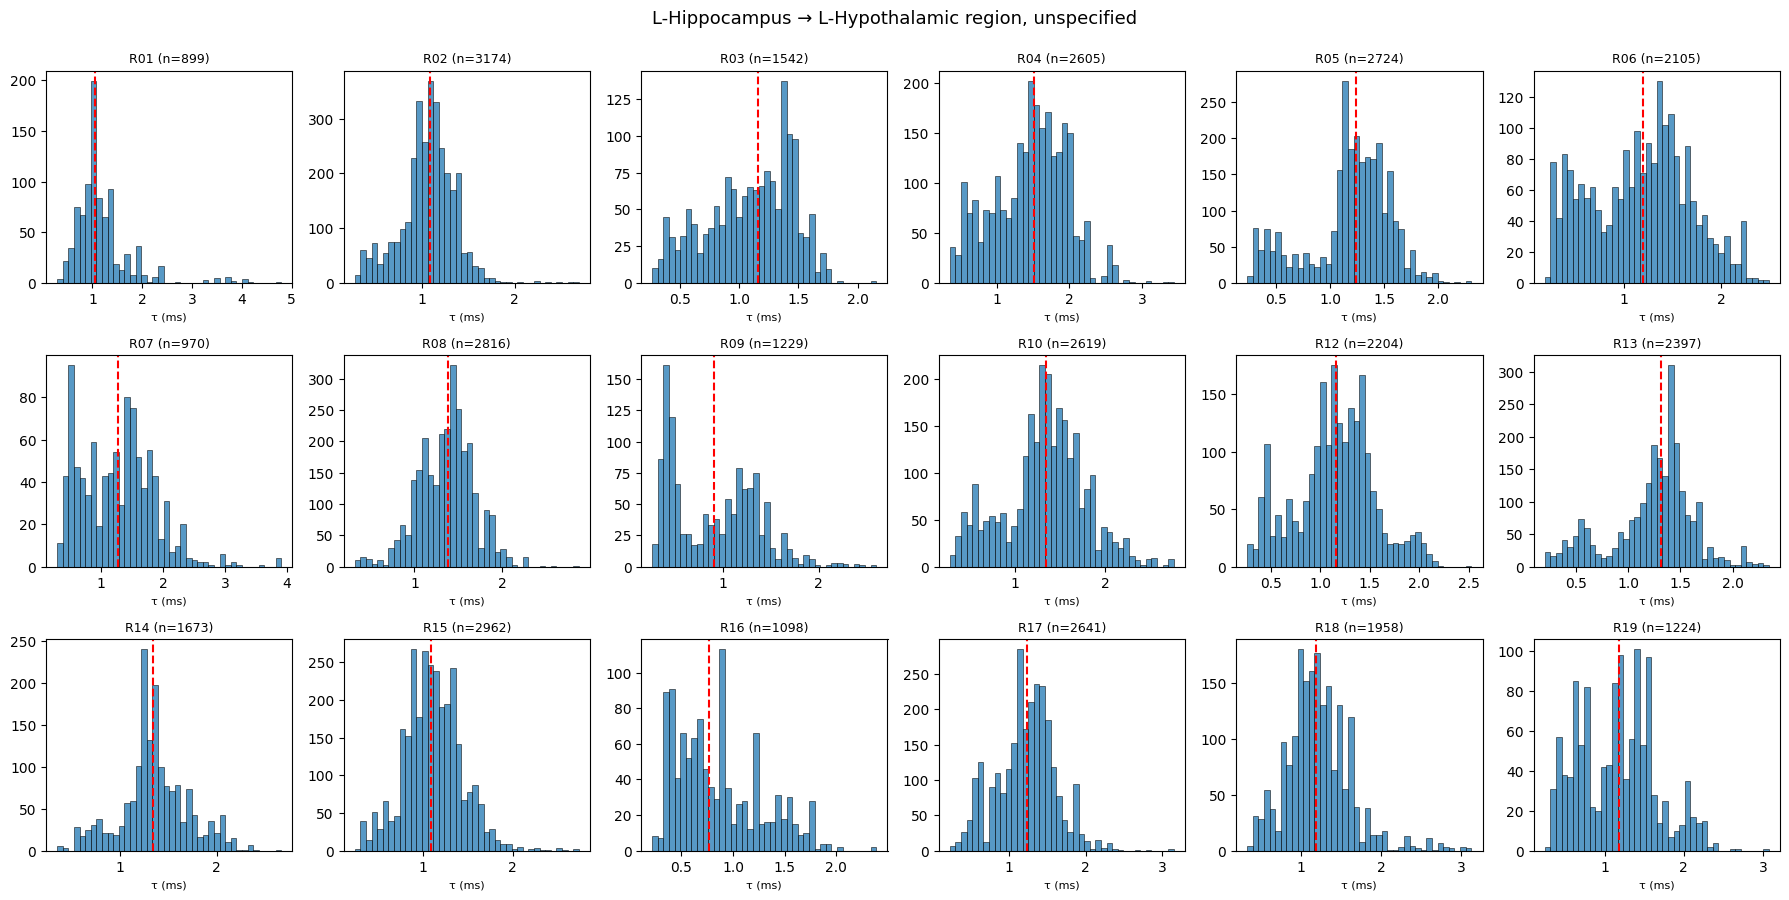

In [14]:
def plot_tau_distributions_multirat(cleaned_rats, pair, name_map, bins=50):
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    axes = axes.ravel()
    
    for idx, (rat_id, data) in enumerate(sorted(cleaned_rats.items())):
        if pair not in data:
            axes[idx].text(0.5, 0.5, 'N/A', ha='center', va='center')
            axes[idx].set_title(rat_id)
            axes[idx].axis('off')
            continue
        
        tau_ms = data[pair][:, COL_TAU] * 1e3
        axes[idx].hist(tau_ms, bins=bins, alpha=0.75, edgecolor='k', linewidth=0.5)
        axes[idx].axvline(np.median(tau_ms), color='r', ls='--', lw=1.5)
        axes[idx].set_title(f"{rat_id} (n={len(tau_ms)})", fontsize=9)
        axes[idx].set_xlabel('τ (ms)', fontsize=8)
    
    i, j = pair
    fig.suptitle(f"{roi_label(i, name_map)} → {roi_label(j, name_map)}", fontsize=13, y=0.995)
    plt.tight_layout()
    return fig

# Top 3
for idx in [0, 1, 2]:
    row = df_stable_diverse.iloc[idx]
    pair = (row['roi_i'], row['roi_j'])
    plot_tau_distributions_multirat(cleaned_rats, pair, name_map, bins=40)
    plt.show()

In [15]:
# Diversificar por estabilidad y anatomía
final_candidates = df_stable_diverse[
    df_stable_diverse['pair_label'].isin([
        'L-Hypothalamic region, unspecified → L-Bed nucleus of the stria terminalis',  # estable, alto n
        'R-Peri-Subiculum → R-Periaqueductal gray',  # heterogéneo (bimodal)
        'L-Hippocampus → L-Hypothalamic region, unspecified',  # estable, alto rango
        'R-Periaqueductal gray → R-Retrosplenial dysgranular area',  # alto n (4965)
        'L-Subiculum → L-Ventral striatal region, unspecified',  # altísimo n (5951)
        'R-Subiculum → R-Periaqueductal gray',  # consistente, n alto
        'L-Zona incerta → L-Hypothalamic region, unspecified',  # corto pero amplio rango
    ])
]
final_candidates

,roi_i,roi_j,pair_label,n_rats,tau_mean_ms,tau_std_inter,cv_inter,tau_range_mean,n_fibers_mean,D_mean_mm,hemi
421,35,42,"L-Hypothalamic region, unspecified → L-Bed nuc...",18,0.927334,0.114198,0.123146,2.844416,1954.166667,6.166801,intra
779,103,114,R-Peri-Subiculum → R-Periaqueductal gray,18,0.891554,0.170247,0.190956,2.712363,1358.055556,5.994340,intra
298,28,35,"L-Hippocampus → L-Hypothalamic region, unspeci...",18,1.189199,0.168987,0.142102,2.625037,2046.666667,8.000906,intra
877,114,132,R-Periaqueductal gray → R-Retrosplenial dysgra...,18,1.221023,0.142707,0.116875,2.543901,4965.944444,7.900550,intra
327,29,53,"L-Subiculum → L-Ventral striatal region, unspe...",18,0.730488,0.087805,0.120200,2.512787,5951.555556,4.048223,intra
72,9,35,"L-Zona incerta → L-Hypothalamic region, unspec...",18,0.363910,0.084045,0.230949,2.479118,1861.000000,2.173754,intra
806,107,114,R-Subiculum → R-Periaqueductal gray,18,1.184051,0.137325,0.115979,2.473557,3932.944444,7.554209,intra


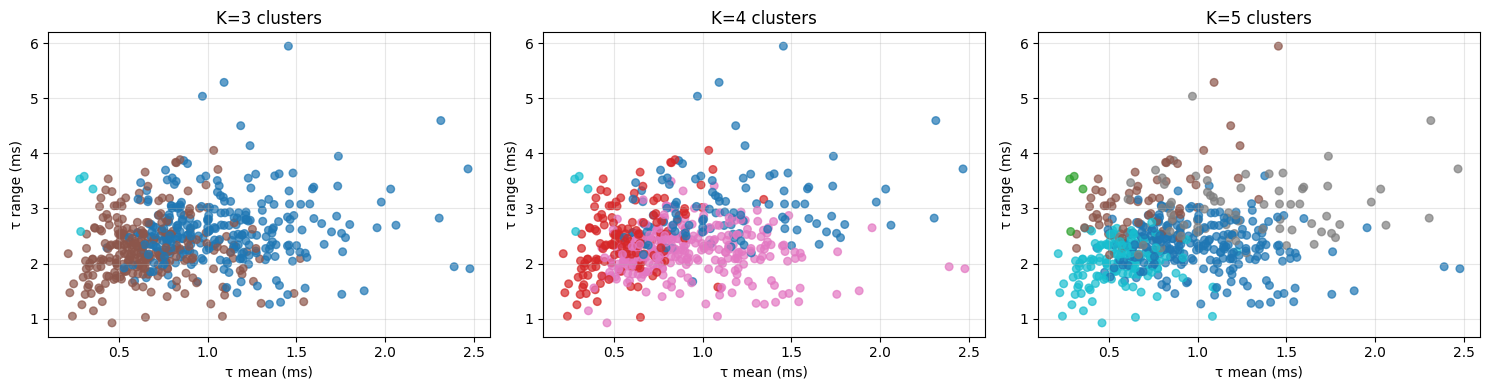

,mean,std,skew,kurt,range
cluster_k4,,,,,
0,1.089926,0.536335,0.636149,0.011786,2.850784
1,0.545074,0.317768,1.726263,5.296758,2.369422
2,0.883054,0.389811,0.271568,0.134267,2.218416
3,0.293330,0.203682,6.233864,80.322556,3.443177


In [17]:
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def characterize_distributions(cleaned_rats, pairs_list):
    """Extrae features por distribución (por rata y conexión)"""
    rows = []
    
    for rat_id, data in cleaned_rats.items():
        for (i, j) in pairs_list:
            if (i, j) not in data:
                continue
            
            tau_ms = data[(i,j)][:, COL_TAU] * 1e3
            
            rows.append({
                'rat_id': rat_id,
                'roi_i': i, 'roi_j': j,
                'pair_label': f"{roi_label(i, name_map)} → {roi_label(j, name_map)}",
                'n': len(tau_ms),
                'mean': tau_ms.mean(),
                'std': tau_ms.std(),
                'skew': stats.skew(tau_ms),
                'kurt': stats.kurtosis(tau_ms),
                'range': np.ptp(tau_ms),
                'p25': np.percentile(tau_ms, 25),
                'p50': np.percentile(tau_ms, 50),
                'p75': np.percentile(tau_ms, 75),
                'iqr': np.percentile(tau_ms, 75) - np.percentile(tau_ms, 25)
            })
    
    return pd.DataFrame(rows)

# Caracterizar top 30 conexiones con alto rango
top_pairs = [(r['roi_i'], r['roi_j']) for _, r in df_stable_diverse.head(30).iterrows()]
df_features = characterize_distributions(cleaned_rats, top_pairs)

# Features para clustering (excluir IDs/labels)
X = df_features[['mean', 'std', 'skew', 'kurt', 'range', 'iqr']].values
X_scaled = StandardScaler().fit_transform(X)
# 
# K-means con k=3,4,5
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for idx, k in enumerate([3, 4, 5]):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    df_features[f'cluster_k{k}'] = labels

    axes[idx].scatter(df_features['mean'], df_features['range'], 
                     c=labels, cmap='tab10', s=30, alpha=0.7)
    axes[idx].set_xlabel('τ mean (ms)')
    axes[idx].set_ylabel('τ range (ms)')
    axes[idx].set_title(f'K={k} clusters')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen por cluster (k=4)
df_features.groupby('cluster_k4')[['mean', 'std', 'skew', 'kurt', 'range']].median()